In [ ]:
                                                                                    
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, time, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
import tensorflow as tf 
from functools import partial

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import KFold
import shutil
import cv2
from statistics import mean
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall,accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau,CSVLogger
from tensorflow.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [ ]:
image_dir = '../input/breakhis/BreaKHis_v1'
data_path = '../input/breakhis/Folds.csv'


# defining the class names
class_names = ['malignant', 'benign']
print(class_names)

['malignant', 'benign']


In [ ]:
data = pd.read_csv(data_path)
data.head(5)
data.drop

<bound method DataFrame.drop of        fold  mag    grp                                           filename
0         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
1         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
2         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
3         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
4         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
...     ...  ...    ...                                                ...
39540     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39541     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39542     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39543     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39544     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...

[39545 rows x 4 columns]>

In [ ]:
data['fold'].value_counts()

1    7909
2    7909
3    7909
4    7909
5    7909
Name: fold, dtype: int64

In [ ]:
data = data.rename(columns={'filename': 'path'})
data['label'] = data.path.apply(lambda x: x.split('/')[3])
data['label_int'] = data.label.apply(lambda x: class_names.index(x))
data['filename'] = data.path.apply(lambda x: x.split('/')[-1])

In [ ]:
data.head(6)

,fold,mag,grp,path,label,label_int,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-003.png
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-004.png
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-005.png
5,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-006.png


In [ ]:
data = data.loc[data['fold']== 1]
data.shape
data.reset_index(drop=True)
data_copy = data


In [ ]:
# Create a new directory to store all available images
all_images_dir = 'all_images_dir'
os.mkdir(all_images_dir)

In [ ]:

data['path'][0]

'BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png'

In [ ]:
print(len(data))

7909


In [ ]:
# This code copies all images from their seperate folders into the same 
# folder called all_images_dir.

for i in range(len(data)):
    src = os.path.join('../input/breakhis/BreaKHis_v1', data['path'][i])
    dst = os.path.join('./all_images_dir', data['filename'][i])
    shutil.copyfile(src, dst)


In [ ]:
len(os.listdir('./all_images_dir'))

7909

In [ ]:
image_list = os.listdir('all_images_dir')

df_data = pd.DataFrame(image_list, columns=['image_id'])



df_data.head()


,image_id
0,SOB_M_MC-14-13418DE-100-009.png
1,SOB_M_DC-14-16188-100-005.png
2,SOB_M_DC-14-2980-100-007.png
3,SOB_B_PT-14-22704-100-002.png
4,SOB_B_PT-14-22704-200-018.png


In [ ]:
data2 = pd.DataFrame()
for i in range(len(df_data)):
    data1 = data.loc[data['filename']== df_data['image_id'][i]]
    data2 = data2.append(data1, ignore_index = True)

In [ ]:

data = data2[['filename','label']]           # only extract the image and class from the dataframe
data = data.rename(columns={"filename":"Image"})
data = data.rename(columns={"label":"Class"})
data.head()
hold_data = data
hold_data.head()

,Image,Class
0,SOB_M_MC-14-13418DE-100-009.png,malignant
1,SOB_M_DC-14-16188-100-005.png,malignant
2,SOB_M_DC-14-2980-100-007.png,malignant
3,SOB_B_PT-14-22704-100-002.png,benign
4,SOB_B_PT-14-22704-200-018.png,benign


malignant    5429
benign       2480
Name: Class, dtype: int64

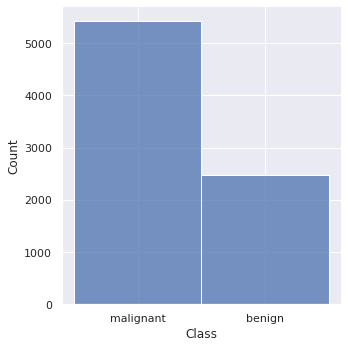

In [ ]:
sns.set_theme()
sns.displot(x='Class', data=data)
data['Class'].value_counts()

**Data splits**

In [ ]:
data = hold_data
min_count = np.min(data.Class.value_counts()) 
data = data.groupby('Class').sample(n=min_count, replace=True)   #set n to number of images for class
data = data.reset_index(drop=True)
print("number of data images:",data['Class'].value_counts())

number of data images: benign       2480
malignant    2480
Name: Class, dtype: int64


In [ ]:
test_images = data.groupby(by='Class').sample(496)
train_images = data.drop(test_images.index).reset_index(drop=True)
test_images = test_images.reset_index(drop=True)
test_images['Class'].value_counts()

benign       496
malignant    496
Name: Class, dtype: int64

In [ ]:
val_images = train_images.groupby(by='Class').sample(496)
train_images = train_images.drop(val_images.index).reset_index(drop=True)
val_images = val_images.reset_index(drop=True)
val_images['Class'].value_counts()


benign       496
malignant    496
Name: Class, dtype: int64

In [ ]:
print(train_images['Class'].value_counts())
X_test = test_images
X_valid = val_images
X_train = train_images

benign       1488
malignant    1488
Name: Class, dtype: int64


In [ ]:
#Storing the average of all predictions

main_pred = []
error = []
data_kfold = pd.DataFrame()
# Creating X, Y for training 



In [ ]:
IMG_SIZE = 299
BATCH_SIZE = 32
EPOCHS = 100
TRAIN_PATH = './all_images_dir'

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.0001,   # minimium amount of change to count as an improvement
    patience=10,   # how many epochs to wait before stopping
    restore_best_weights=True,)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.000001,verbose = 1) #LR is multiplied by 'factor' if there is no improvement

csv_logger = CSVLogger('log.csv', append=True, separator=';')

**model initialization**

In [ ]:
def get_model(IMG_SIZE):
    from tensorflow.keras.applications import InceptionV3
    pre_trained_model = InceptionV3(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
    for layer in pre_trained_model.layers:
        layer.trainable = False

    last_layer = pre_trained_model
    last_output = last_layer.output
    
    x= GlobalAveragePooling2D()(last_output)
    x = layers.Flatten()(x)
    
    x = Dense(1024, activation="relu")(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(512, activation="relu")(x)
    x = Dense(2, activation="softmax")(x)

    model = Model(pre_trained_model.input, x)

    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.000005),
                  metrics=['accuracy'])

    return model

**Data Generators**

In [ ]:
#Initializing Data Generators
test_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)
                                     
validation_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

    
test_set = test_generator.flow_from_dataframe(dataframe=X_test, directory=TRAIN_PATH,
                                                 x_col="Image",y_col="Class",
                                                 shuffle = False,
                                                 class_mode="categorical",
                                                 target_size=(IMG_SIZE,IMG_SIZE))


training_set = train_datagen.flow_from_dataframe(dataframe=X_train, directory=TRAIN_PATH,
                                                 x_col="Image", y_col="Class",
                                                 class_mode="categorical",
                                                 target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)
    
validation_set = validation_datagen.flow_from_dataframe(dataframe=X_valid, directory=TRAIN_PATH,
                                                 x_col="Image", y_col="Class",
                                                 class_mode="categorical",
                                                 target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)
    


Found 992 validated image filenames belonging to 2 classes.
Found 2976 validated image filenames belonging to 2 classes.
Found 992 validated image filenames belonging to 2 classes.


**Model training**

In [ ]:
model_test = get_model(IMG_SIZE)                        
history = model_test.fit(training_set,
                                    validation_data=validation_set,
                                    epochs = EPOCHS,
                                    steps_per_epoch=len(training_set),
                                    callbacks = [early_stopping,reduce_lr,csv_logger]
                                  )

2022-03-26 19:37:33.164188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 19:37:33.249309: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 19:37:33.250045: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-26 19:37:33.251799: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 1s 0us/step


2022-03-26 19:37:38.746276: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 34329984 exceeds 10% of free system memory.
2022-03-26 19:37:38.897903: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-03-26 19:37:43.192632: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 34329984 exceeds 10% of free system memory.
2022-03-26 19:37:43.837145: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 34329984 exceeds 10% of free system memory.
2022-03-26 19:37:44.121391: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 3/93 [..............................] - ETA: 27s - loss: 0.7069 - accuracy: 0.5312

2022-03-26 19:37:50.268186: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 34329984 exceeds 10% of free system memory.


 4/93 [>.............................] - ETA: 35s - loss: 0.6985 - accuracy: 0.5547

2022-03-26 19:37:50.878270: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 34329984 exceeds 10% of free system memory.


93/93 [==============================] - 83s 781ms/step - loss: 0.6343 - accuracy: 0.6633 - val_loss: 0.5863 - val_accuracy: 0.7258
Epoch 2/100
93/93 [==============================] - 67s 724ms/step - loss: 0.5361 - accuracy: 0.7554 - val_loss: 0.5241 - val_accuracy: 0.7631
Epoch 3/100
93/93 [==============================] - 67s 719ms/step - loss: 0.4792 - accuracy: 0.7930 - val_loss: 0.4831 - val_accuracy: 0.7863
Epoch 4/100
93/93 [==============================] - 67s 718ms/step - loss: 0.4403 - accuracy: 0.8075 - val_loss: 0.4536 - val_accuracy: 0.7994
Epoch 5/100
93/93 [==============================] - 67s 720ms/step - loss: 0.4086 - accuracy: 0.8199 - val_loss: 0.4299 - val_accuracy: 0.8115
Epoch 6/100
93/93 [==============================] - 67s 720ms/step - loss: 0.3841 - accuracy: 0.8380 - val_loss: 0.4151 - val_accuracy: 0.8226
Epoch 7/100
93/93 [==============================] - 67s 723ms/step - loss: 0.3607 - accuracy: 0.8471 - val_loss: 0.3966 - val_accuracy: 0.8317
Epoc

In [ ]:
from keras.models import load_model
model_test.save('my_model.h5')

Graphs

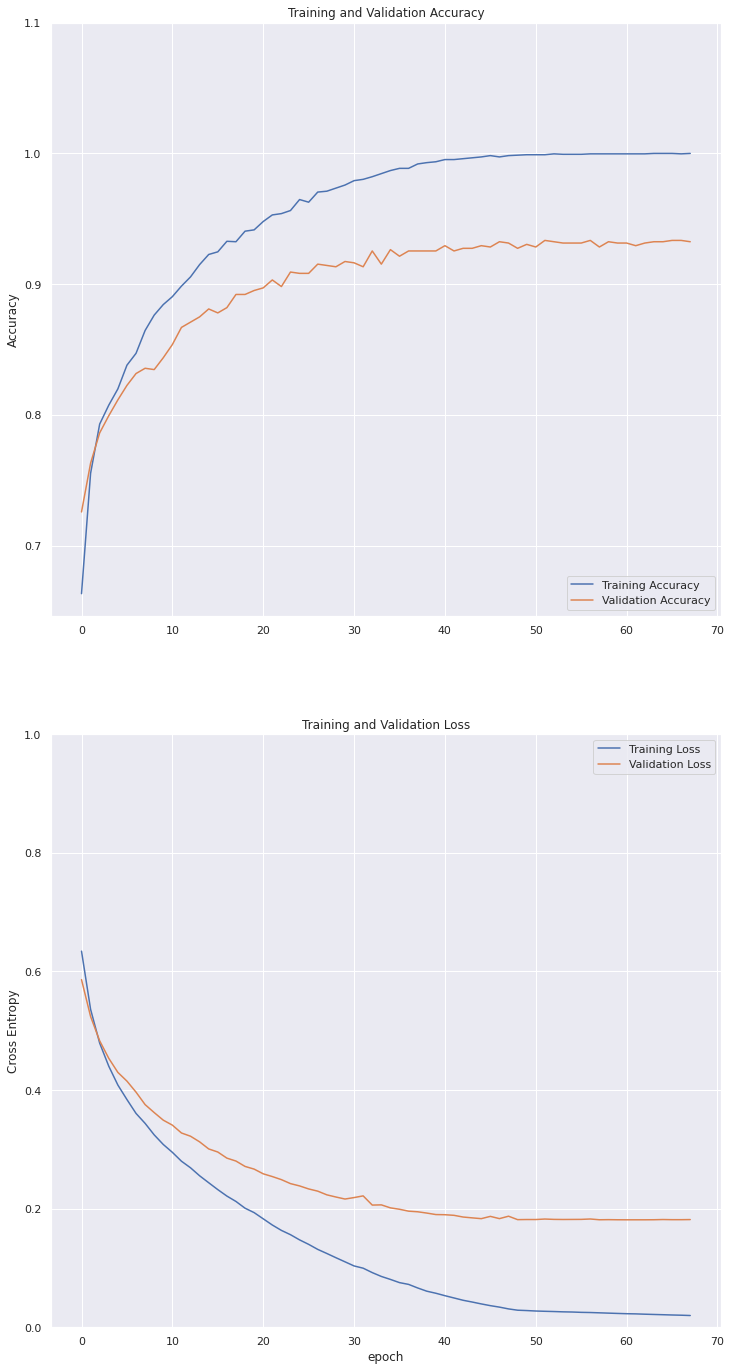

In [ ]:
#learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
default_x_ticks = range(len(acc))
plt.figure(figsize=(12, 24))
plt.subplot(2, 1, 1)
plt.plot(default_x_ticks,acc, label='Training Accuracy')
plt.plot(default_x_ticks,val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(default_x_ticks,loss, label='Training Loss')
plt.plot(default_x_ticks,val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
from time import sleep
import time
start = time.process_time() 
Y_pred = model_test.predict(test_set)
end = time.process_time()
print("Time per image: {} second".format((end-start)/len(X_test)))
predicted_class_indices = np.argmax(Y_pred,axis=1)

Time per image: 0.017842648147177075 second


In [ ]:
Y_pred

0.99999976

In [ ]:
labels=(training_set.class_indices)
labels2=dict((v,k) for k,v in labels.items())
predictions=[labels2[k] for k in predicted_class_indices] 

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,                  #Confusion matrix with heatmap
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   

In [ ]:
# Get the labels of the test images.

test_labels = X_test.Class
test_labels.shape
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions)
# Print the label associated with each class
 
print(test_set.class_indices)
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['benign', 'malignant']


{'benign': 0, 'malignant': 1}


Confusion matrix, without normalization
[[459  37]
 [ 38 458]]
Accuracy: 0.924
Precision: 0.925
Recall: 0.925


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


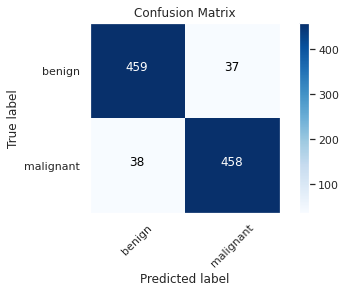

In [ ]:
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[1,0] # false positives
FN = cm[0,1] # false negatives

    
TPR = TP/(TP+FN) #Sensitivity
TNR = TN/(TN+FP) #Specifity
PPV = TP/(TP+FP) #Precision
NPV = TN/(TN+FN) # Negative predictive value
FPR = FP/(FP+TN) # Fall out or false positive rate
FNR = FN/(TP+FN) # False negative rate
FDR = FP/(TP+FP) # False discovery rate

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN) #Accuracy


print(f"Trial Metrics:")
print(f"Sensitivity: {TPR}\nSpecifity: {TNR}\nPrecision: {PPV}\nAccuracy: {ACC}")

Trial Metrics:
Sensitivity: 0.9252525252525252
Specifity: 0.9235412474849095
Precision: 0.9233870967741935
Accuracy: 0.9243951612903226


In [ ]:

print(classification_report(X_test.Class,predictions,digits=3))


              precision    recall  f1-score   support

      benign      0.924     0.925     0.924       496
   malignant      0.925     0.923     0.924       496

    accuracy                          0.924       992
   macro avg      0.924     0.924     0.924       992
weighted avg      0.924     0.924     0.924       992



In [ ]:
# save predicitions to csv file
prediction12 = pd.DataFrame(predictions, columns=['predictions']).to_csv('prediction.csv')
